In [10]:
import pandas as pd
import numpy as np
import pickle
import nltk
%matplotlib inline

## Environments

In [2]:
# Path to the data file
DATA_PATH = "/Users/xiaoma/Desktop/kaggle/toxicComments/data/toxic_balanced.csv"

# Path to the Glove embedding file
GLOVE_PATH = "/Users/xiaoma/Desktop/glove_emb/glove.6B.100d.txt"

## Read data

In [3]:
data = pd.read_csv(DATA_PATH)
# sample the data for computation efficiency
data = data.sample(2000)

## Split into training and testing sets

In [4]:
"""
Training and testing split
"""
import random
random.seed(923)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.comment_text, data.toxic, test_size = 0.25,random_state = 23)

X_train.reset_index(drop = True,inplace = True)
X_test.reset_index(drop = True,inplace = True)
y_train.reset_index(drop = True,inplace = True)
y_test.reset_index(drop = True,inplace = True)

## Text Pre-processing

In this step, we can apply additional pre-processing before tokenization. Namely lemmatization/stemming

In [5]:
from tokenizer_xm import text_tokenizer_xm, contractions

doc_train_processed = text_tokenizer_xm(text = X_train,lemma_flag = True, stem_flag = False, \
                                           stopwords=[],contractions = contractions).txt_pre_pros_all()

print("Results of pre_processing:")
print("Original text:")
print(X_train[0])
print("Processed:")
print(doc_train_processed[0])

Results of pre_processing:
Original text:
BLOCKED 

why did you block me? is it because so you can get that stupid graphic star. how dumb. please dont as i have not vandelised any page so get used to it you idiot.
Processed:
['block', 'why', 'do', 'you', 'block', 'me', 'be', 'it', 'because', 'so', 'you', 'can', 'get', 'that', 'stupid', 'graphic', 'star', 'how', 'dumb', 'please', 'dont', 'a', 'have', 'not', 'vandelised', 'any', 'page', 'so', 'get', 'use', 'to', 'it', 'you', 'idiot']


Next we need to turn the text tokens into numeric vectors. The keras tokenizer can be applied directly to raw text. In this case, we use it on tokenized text

In [6]:
from keras.preprocessing.text import Tokenizer
# Create the tokenizer
t = Tokenizer()
# Fit the tokenizer on the documents
t.fit_on_texts(doc_train_processed)

Using TensorFlow backend.


As of the keras version 2.2.4, we cannot apply filters to the tokenizer to have it filter out the rare tokens. Hence we need to do it manually 

In [7]:
"""
Find tokens appears less than 20 times
"""
rare = []
for word, count in t.word_counts.items():
    if count <=20:
        rare.append(word)
        

"""
The word index for keras Tokenizer is ordered based on frequency. Therefore we can do the following according to
https://github.com/keras-team/keras/issues/8092
"""
num_words_to_keep = int(round((len(t.word_index) - len(rare)) * 1.05,0))
t.oov_token = '_unknown_'
t.word_index = {e:i for e,i in t.word_index.items() if i <= num_words_to_keep} # <= because tokenizer is 1 indexed
t.word_index[t.oov_token] = num_words_to_keep + 1

"""
Apply the tokenizer
"""
encoded_docs = t.texts_to_sequences(doc_train_processed)


print("Original text:")
print(X_train[0])
print("Processed:")
print(doc_train_processed[0])
print("Vectorized:")
print(encoded_docs[0])

Original text:
BLOCKED 

why did you block me? is it because so you can get that stupid graphic star. how dumb. please dont as i have not vandelised any page so get used to it you idiot.
Processed:
['block', 'why', 'do', 'you', 'block', 'me', 'be', 'it', 'because', 'so', 'you', 'can', 'get', 'that', 'stupid', 'graphic', 'star', 'how', 'dumb', 'please', 'dont', 'a', 'have', 'not', 'vandelised', 'any', 'page', 'so', 'get', 'use', 'to', 'it', 'you', 'idiot']
Vectorized:
[64, 83, 11, 3, 64, 22, 1, 7, 56, 38, 3, 34, 54, 10, 177, 523, 523, 75, 523, 68, 256, 20, 8, 9, 523, 79, 25, 38, 54, 58, 4, 7, 3, 237]


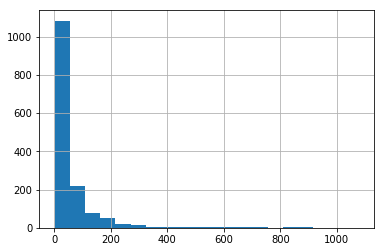

In [11]:
"""
Decide the max length of documents
"""
pd.Series(encoded_docs).apply(lambda x: len(x)).hist(bins = 20);

"""
Padding
"""
from keras.preprocessing.sequence import pad_sequences
max_len = 200

padded_doc = pad_sequences(encoded_docs, maxlen = max_len, padding = 'post')

## Load the pre-trained models

In [13]:
"""
Load the embedded words into memory
"""
# load the whole embedding into memory
embeddings_index = dict()
f = open(GLOVE_PATH,encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [14]:
"""
Create the weight matrix for terms in training doc
"""
vocab_size = len(t.word_index) + 1

embedding_matrix = np.zeros((vocab_size, 100))
# Log the terms that didn't get the embedding
none_count = 0
none_terms = list()

for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        none_count = none_count + 1
        none_terms.append(word)

## Define the model

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Bidirectional,Input,Conv1D,\
MaxPooling1D
from keras.models import Model
from keras import losses, metrics
from keras.optimizers import adam

def create_model(neuron_num = 50,print_summary = False):
    
    inp = Input(shape = (max_len,))

    # We don't want to update the weights. Therefore we set "trainable" to False
    embedding = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_len, trainable=False)(inp)

    # Add a convolution layer.
    conv1 = Conv1D(filters = 32, kernel_size = 5,padding = 'same')(embedding)

    # Add a max-pooling layer. To understand "strides," check out the following video by Andrew Ng:
    # https://www.youtube.com/watch?v=8oOgPUO-TBY

    maxp1 = MaxPooling1D(pool_size = 5,strides = 1,padding = 'same')(conv1)
    
    dropout1 = Dropout(0.4)(maxp1)

    lstm1 = Bidirectional(LSTM(neuron_num,return_sequences = False,dropout = 0.2,recurrent_dropout = 0.2))(dropout1)
    
    dense1 = Dense(50,activation = 'relu')(lstm1)
            
    dense2 = Dense(1,activation = 'sigmoid')(dense1)

    model = Model(inputs = inp, outputs = dense2)
    
    # Define the optimizer
    optm = adam(lr = 0.001)

    model.compile(loss=['binary_crossentropy'], optimizer=optm, metrics=['binary_accuracy'])
    
    if print_summary:
        print(model.summary())
    
    return model
    
    
model = create_model(print_summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 100)          52400     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 32)           16032     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 200, 32)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 32)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               33200     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
__________

Update from August 2019:

Consider recified adam as the optimizer:

https://pypi.org/project/keras-radam/

https://medium.com/@lessw/new-state-of-the-art-ai-optimizer-rectified-adam-radam-5d854730807b

In [18]:
"""
Defining early-stopping callback
"""
from keras.callbacks import EarlyStopping
# Define an early-stopping callback
cb = [EarlyStopping(monitor='val_loss',patience = 2)]

## Train the model

In [20]:
"""
Training the model
"""
batch_size = 32
num_epochs = 20
#
x_training = padded_doc
y_training = y_train.values

model.fit(x_training, y_training,validation_split=0.2,\
          batch_size=batch_size, epochs=num_epochs,verbose=1,callbacks =cb)

Instructions for updating:
Use tf.cast instead.
Train on 1200 samples, validate on 300 samples
Epoch 1/20
1200/1200 [==============================] - 10s 9ms/step - loss: 0.6623 - binary_accuracy: 0.5992 - val_loss: 0.5915 - val_binary_accuracy: 0.7167
Epoch 2/20
1200/1200 [==============================] - 8s 7ms/step - loss: 0.5451 - binary_accuracy: 0.7342 - val_loss: 0.5464 - val_binary_accuracy: 0.7100
Epoch 3/20
1200/1200 [==============================] - 8s 7ms/step - loss: 0.4664 - binary_accuracy: 0.7833 - val_loss: 0.4848 - val_binary_accuracy: 0.7700
Epoch 4/20
1200/1200 [==============================] - 8s 7ms/step - loss: 0.4044 - binary_accuracy: 0.8250 - val_loss: 0.4462 - val_binary_accuracy: 0.8000
Epoch 5/20
1200/1200 [==============================] - 8s 6ms/step - loss: 0.3750 - binary_accuracy: 0.8392 - val_loss: 0.4318 - val_binary_accuracy: 0.8000
Epoch 6/20
1200/1200 [==============================] - 8s 6ms/step - loss: 0.3865 - binary_accuracy: 0.8450 - val

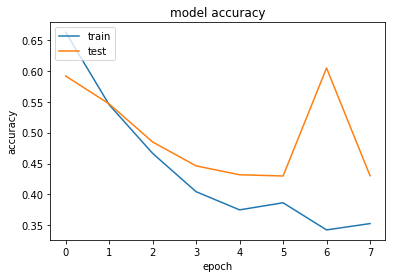

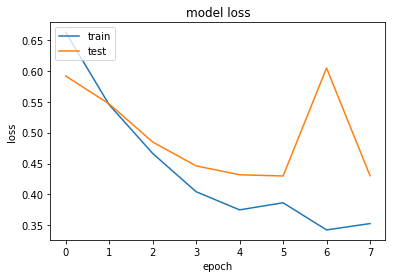

In [25]:
"""
plot the history 
"""
from matplotlib import pyplot as plt
plt.figure(0)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# loss
plt.figure(1)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


In [27]:
"""
Evalutaion
"""
model = model
# Get the test data. Evalutate on 5000 examples
test_processed = text_tokenizer_xm(text = X_test,lemma_flag = True, stem_flag = False, \
                                           stopwords=[],contractions = contractions).txt_pre_pros_all()

encoded_test_doc = t.texts_to_sequences(test_processed)
padded_test_doc = pad_sequences(encoded_test_doc, maxlen = max_len, padding = 'post')

model.evaluate(padded_test_doc, y_test)

500/500 [==============================] - 1s 1ms/step


[0.4470547251701355, 0.8200000009536743]

## Optional: Tuning with Grid Search

In [ ]:
"""
Set up hyper-parameter tunning
"""
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV

# Define the model
model = KerasClassifier(build_fn = create_model)

# Define batch size and epochs
batch_size = [32,64]
epochs = [3,4]
lr_rates = [0.001,0.005, 0.01]
drop_outs = [0.1,0.2]
neuron_sizes = [50,100,150]
param_grid = dict(neuron_num = neuron_sizes)

grid = RandomizedSearchCV(estimator = model, param_distributions = param_grid,cv = 30)

# Define an early-stopping callback
cb = [EarlyStopping(monitor='val_loss',patience = 2)]

grid_result = grid.fit(X = padded_doc, y = y_train.values, callbacks = cb,validation_split=0.1)